<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Разности временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Напишем-функцию-для-создания-признаков" data-toc-modified-id="Напишем-функцию-для-создания-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Напишем функцию для создания признаков</a></span></li><li><span><a href="#Тест-Дики-Фуллера" data-toc-modified-id="Тест-Дики-Фуллера-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тест Дики-Фуллера</a></span></li><li><span><a href="#Автокорреляция" data-toc-modified-id="Автокорреляция-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Автокорреляция</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Проверим-модель-на-адекватность" data-toc-modified-id="Проверим-модель-на-адекватность-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверим модель на адекватность</a></span></li></ul></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель:** Построить модель, которая умеет прогнозировать количество заказов такси на следующий час.
     
   Работа пройдёт в несколько этапов:
 1. Загрузка и подготовка данных.
 2. Анализ.
 3. Обучение моделей.
 4. Тестирование моделей.
 5. Общий вывод.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.signal import find_peaks

from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)

RANDOM_STATE = 123

## Подготовка

In [2]:
# загрузим датасет
if os.path.exists('12.1. taxi.csv'):
    df = pd.read_csv('12.1. taxi.csv', index_col=[0], parse_dates=[0])
elif os.path.exists('/datasets/taxi.csv'):
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    print('Nothing works.')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**У нас данные за полгода.**

**Проверим, в хронологическом ли порядке расположены даты и время.**

In [4]:
df.index.is_monotonic

True

In [5]:
# проверим пропуски
df.isna().sum()

num_orders    0
dtype: int64

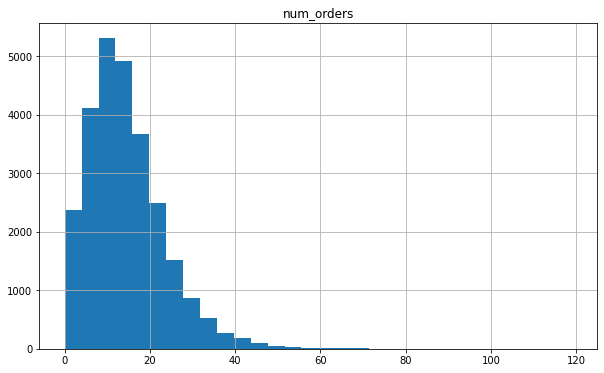

In [6]:
df.hist(figsize=(10, 6), bins=30);

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
# посмотрим на дату максимального значения
df[df.num_orders == df.num_orders.max()]

,num_orders
datetime,
2018-08-13 02:20:00,119
2018-08-27 02:10:00,119


**Сделаем ресемплирование по одному часу.**

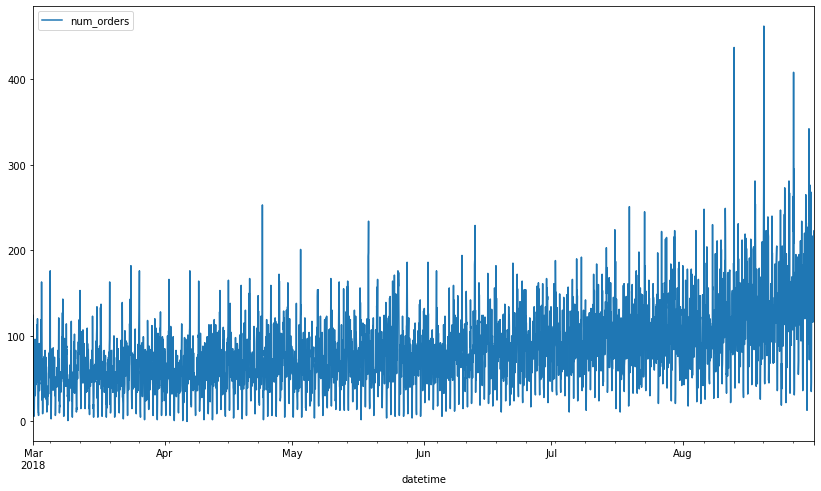

In [9]:
df_hour = df.resample('1H').sum()
df_hour.plot(figsize=(14, 8));

**Вывод:**  
+ у нас данные за полгода     
+ данные идут в хронологическом порядке     
+ пропуски отсутствуют    
+ сделали ресемплирование по одному часу

## Анализ

**Посмотрим на уникальность дат.**

In [10]:
df_hour.index.is_unique

True

In [11]:
df_day = df.resample('1D').sum()

### Скользящее среднее

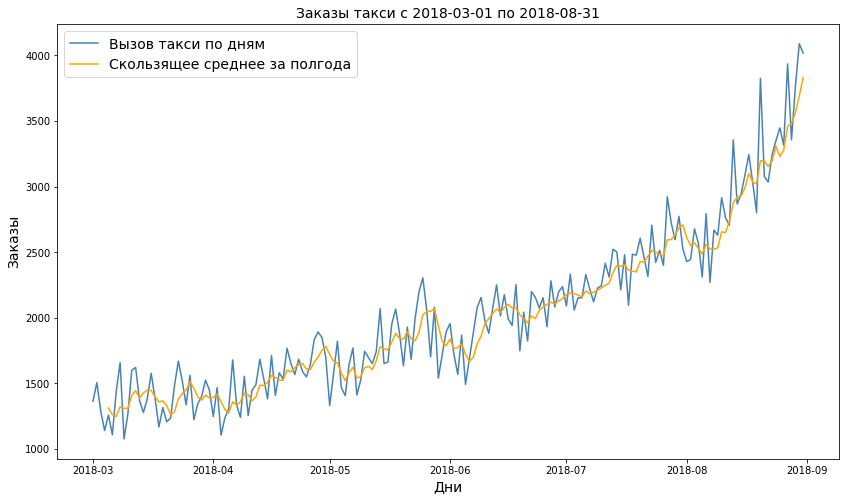

In [12]:
plt.figure(figsize = (14,8))
plt.plot(df_day, label = 'Вызов такси по дням', color = 'steelblue')
plt.plot(df_day.rolling(5).mean(), label = 'Скользящее среднее за полгода', color = 'orange')
plt.legend(fontsize=14)
plt.xlabel('Дни', fontsize=14)
plt.ylabel('Заказы', fontsize=14)
plt.title('Заказы такси с 2018-03-01 по 2018-08-31', fontsize=14);

**Мы видим, что заказы такси начинают расти с начала июня, когда люди начинают уходит в отпуск.**

### Тренды и сезонность

**Разложим временной ряд на тренд и сезонную компоненту.**

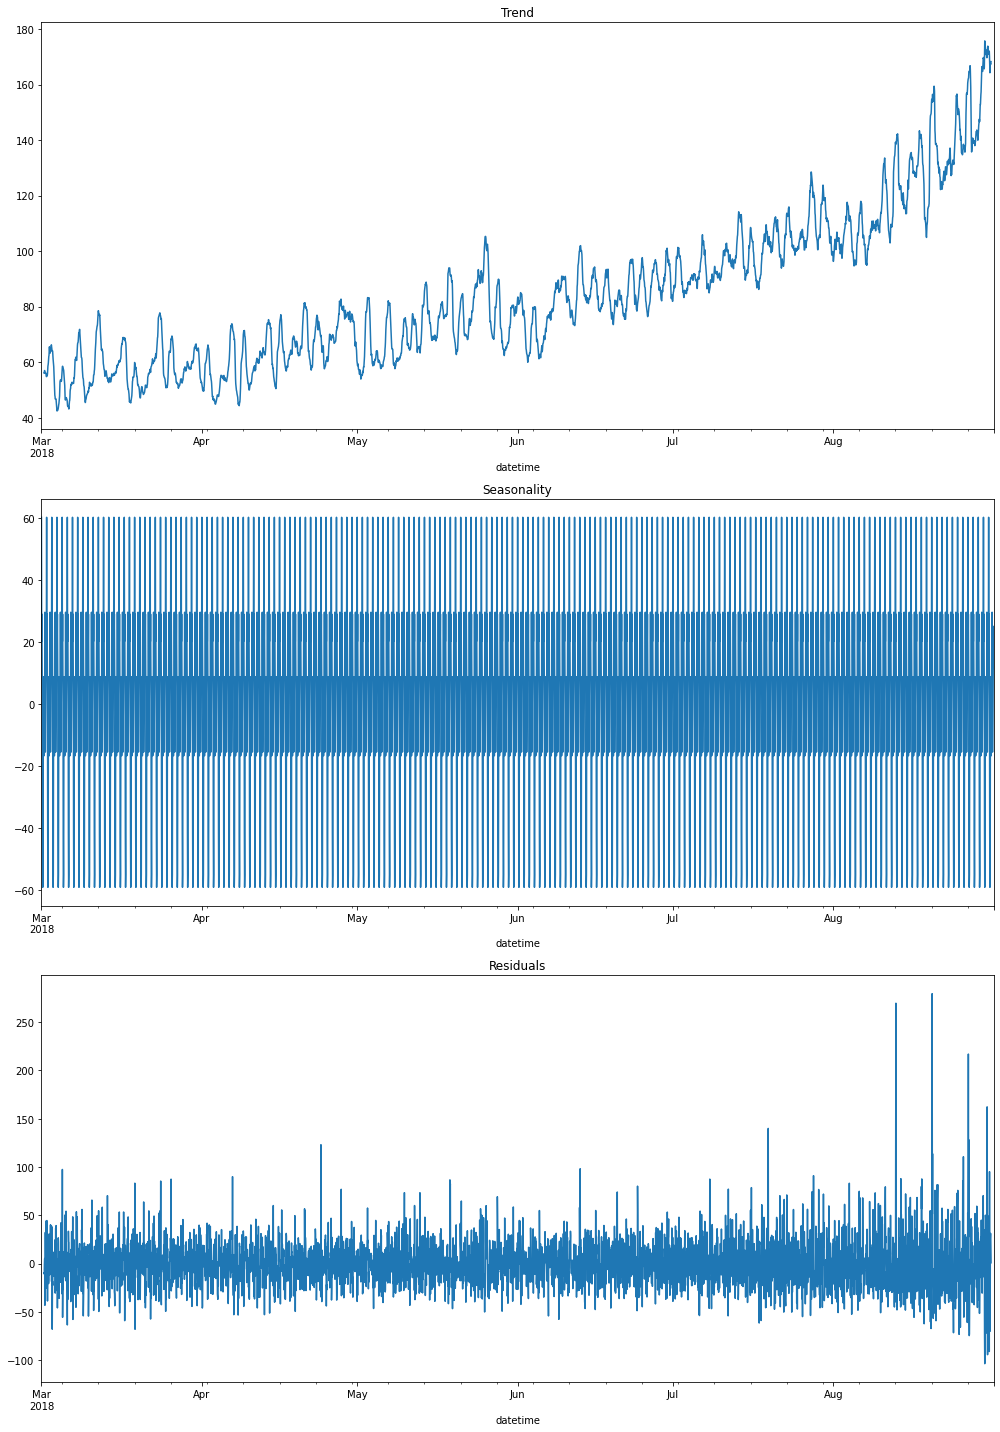

In [13]:
decomposed_h = seasonal_decompose(df_hour)

plt.figure(figsize=(14, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed_h.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_h.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_h.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

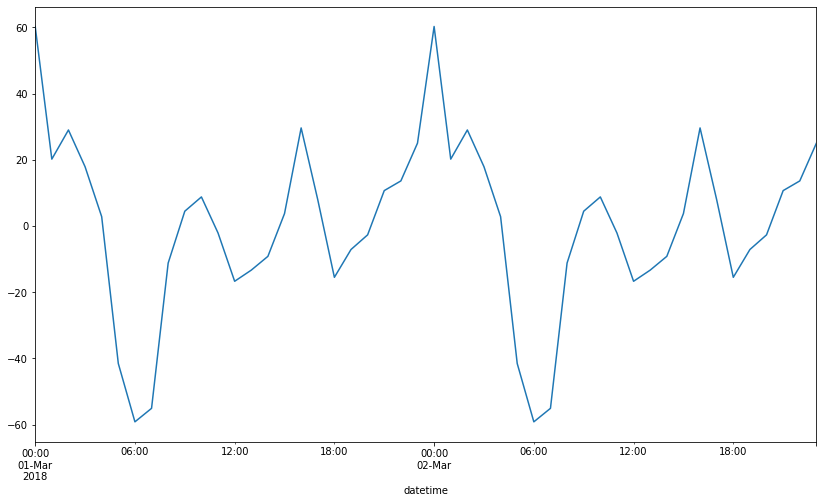

In [14]:
decomposed_h.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(14, 8));

**Основные заказы поступают в полночь и около 16.00.**

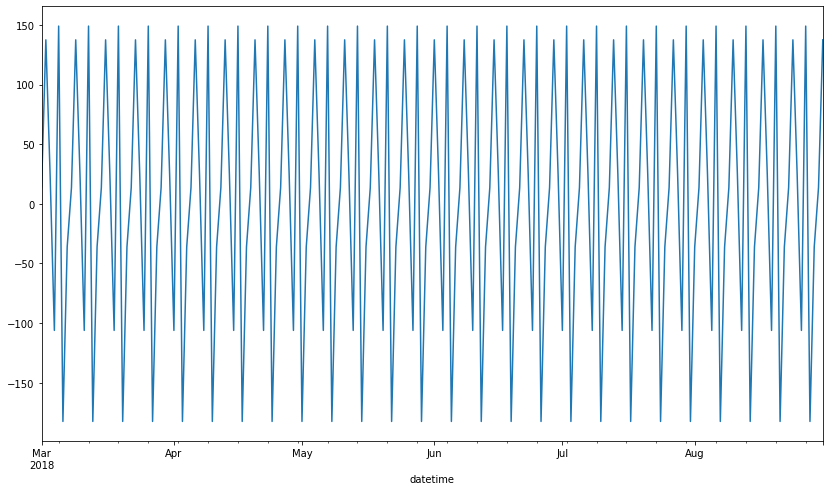

In [15]:
decomposed_d = seasonal_decompose(df_day)
decomposed_d.seasonal.plot(figsize=(14, 8));

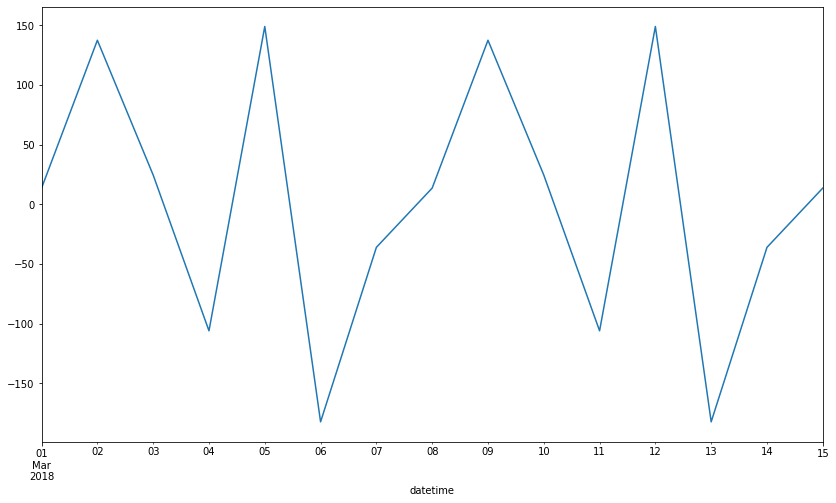

In [16]:
decomposed_d.seasonal['2018-03-01':'2018-03-15'].plot(figsize=(14, 8));

In [17]:
# посмотрим каким днём недели является 2018-03-05
df_day[df_day.index == '2018-03-05'].index.dayofweek

Int64Index([0], dtype='int64', name='datetime')

**По дням, люди уезжают в начале и в конце недели. В понедельник и пятницу.**

### Разности временного ряда

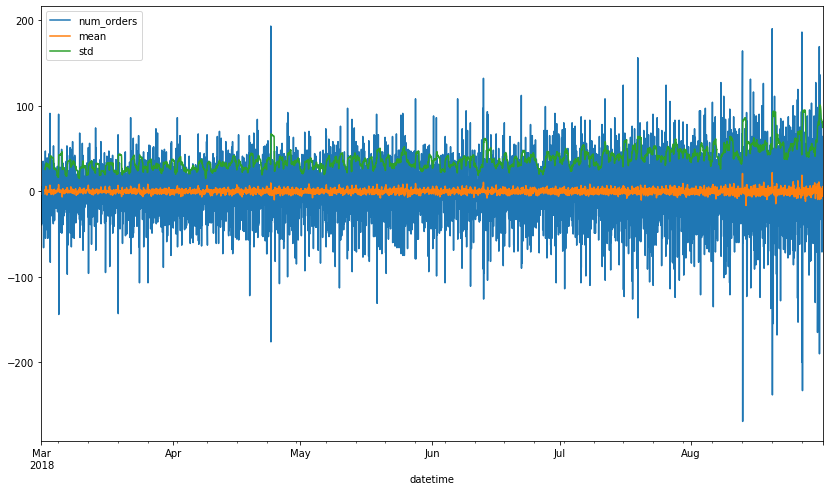

In [18]:
data_diff = df_hour - df_hour.shift()
data_diff['mean'] = data_diff['num_orders'].rolling(20).mean()
data_diff['std'] = data_diff['num_orders'].rolling(20).std()
data_diff.plot(figsize=(14, 8));

**Ряд стал более стационапным.**

**Вывод:**    
+ основной рост заказов наблюдается с начала июня      
+ основные заказы поступают в полунуночь и в 16.00.    
+ больше всего заказов в понедельник и пятницу

## Обучение

### Напишем функцию для создания признаков

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    df_upg = data.copy()
    df_upg['year'] = df_upg.index.year
    df_upg['month'] = df_upg.index.month
    df_upg['day'] = df_upg.index.day
    df_upg['dayofweek'] = df_upg.index.dayofweek
    # ассиметрия
    df_upg['skew'] = df_upg['num_orders'].rolling(6).apply(lambda x: pd.DataFrame(x).skew()[0])
    # пики
    df_upg['peaks'] = df_upg['num_orders'].rolling(6).apply(lambda x: len(find_peaks(x)[0])) 
    
    for lag in range(1, max_lag + 1):
        df_upg[f'lag_{lag}'] = df_upg['num_orders'].shift(lag)

    df_upg['rolling_mean'] = df_upg['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_upg['expanding_mean'] = df_upg['num_orders'].expanding(2).mean()
    return df_upg

### Тест Дики-Фуллера

**Выполним тест Дики-Фуллера**

In [21]:
dftest = adfuller(df_hour.num_orders, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Количество лагов, используемых в регрессии для определения t-статистики : ", dftest[2])
print("4. Количество наблюдений, использованных в анализе :", dftest[3])
print("5. Критические значения :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.0689242890279558
2. P-Value :  0.028940051402612906
3. Количество лагов, используемых в регрессии для определения t-статистики :  30
4. Количество наблюдений, использованных в анализе : 4385
5. Критические значения :
	 1% :  -3.431842162413052
	 5% :  -2.8621993540813637
	 10% :  -2.567120978470452


### Автокорреляция

**Посмотрим на автокорреляцию. Определим сколько лагов строить.**

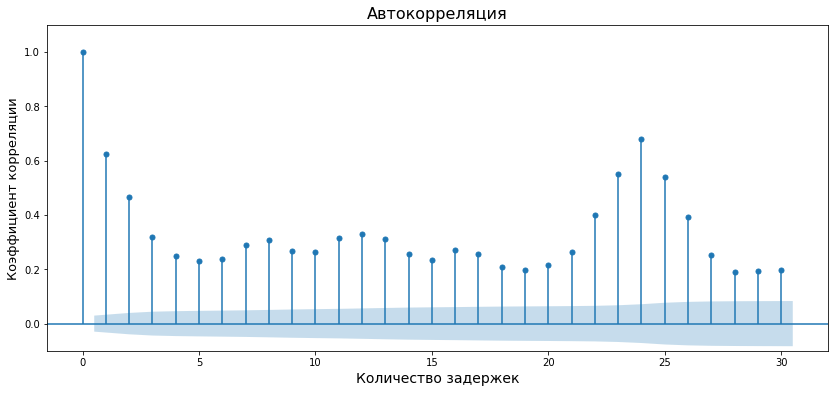

In [22]:
plt.rc("figure", figsize=(14, 6))
fig = plot_acf(df_hour, lags=30)
plt.ylim(-.1, 1.1)
plt.title('Автокорреляция', fontsize=16)
plt.xlabel('Количество задержек', fontsize=14)
plt.ylabel('Коэффициент корреляции', fontsize=13);

**Синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна и ее можно использовать при построении модели.**

In [23]:
df_hour_upg = make_features(df_hour, 27, 10)

In [24]:
df_hour_upg.head()

,num_orders,year,month,day,dayofweek,skew,peaks,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,rolling_mean,expanding_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.500000
2018-03-01 02:00:00,71,2018,3,1,3,NaN,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 03:00:00,66,2018,3,1,3,NaN,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.500000
2018-03-01 04:00:00,43,2018,3,1,3,NaN,NaN,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.800000


In [25]:
# создадим scorer для RMSE
def rmse(y, pred):
    return  mean_squared_error(y, pred, squared=False)
RMSE_scorer = make_scorer(rmse, greater_is_better=False)

In [26]:
# разобьём сначала на обучающий и тестовый наборы
train, test = train_test_split(df_hour_upg, shuffle=False, test_size=0.1)

In [27]:
train.shape,test.shape

((3974, 36), (442, 36))

In [28]:
# удвлим пропуски из трейна
train = train.dropna()

In [29]:
train.shape,test.shape

((3947, 36), (442, 36))

In [30]:
# разобьём данные на признаки и целевой признак
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [31]:
# проверим длины наших выборок
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3947, 35), (3947,), (442, 35), (442,))

In [32]:
# проверим корректно ли поделены данные
print(X_train.index.min(), X_train.index.max(), X_test.index.min(), X_test.index.max())
print(y_train.index.min(), y_train.index.max(), y_test.index.min(), y_test.index.max())

2018-03-02 03:00:00 2018-08-13 13:00:00 2018-08-13 14:00:00 2018-08-31 23:00:00
2018-03-02 03:00:00 2018-08-13 13:00:00 2018-08-13 14:00:00 2018-08-31 23:00:00


### Линейная регрессия

In [33]:
tss_cv = TimeSeriesSplit(n_splits=3)

In [34]:
%%time
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
RMSE = -cross_val_score(model_LR, X_train, y_train, scoring=RMSE_scorer, cv=tss_cv).mean()
print(f'Лучшее значение RMSE для линейной регрессии: {RMSE:.6f}')

Лучшее значение RMSE для линейной регрессии: 26.606064
CPU times: user 229 ms, sys: 285 ms, total: 514 ms
Wall time: 479 ms


### Случайный лес

In [35]:
%%time
grid_par_RF = {'max_depth': [17, 18, 19], 
              'n_estimators': [612, 613, 614]}
model_RF = RandomForestRegressor(random_state=RANDOM_STATE)
cv_RF = GridSearchCV(model_RF, grid_par_RF, scoring=RMSE_scorer, cv=tss_cv, n_jobs=-1)
cv_RF.fit(X_train, y_train)
print(f'Лучший параметр: {cv_RF.best_params_}\nЛучший показатель RMSE: {-cv_RF.best_score_:.6f}')

Лучший параметр: {'max_depth': 18, 'n_estimators': 613}
Лучший показатель RMSE: 26.185567
CPU times: user 8min 24s, sys: 810 ms, total: 8min 25s
Wall time: 8min 26s


### LightGBM

In [36]:
%%time
grid_par_LGBM = {'max_depth': [11, 12, 13],
                'n_estimators': [141, 142, 143],
                'num_leaves': [112, 113, 114]}
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE)
cv_LGBM = GridSearchCV(model_LGBM, grid_par_LGBM, scoring=RMSE_scorer, cv=tss_cv, n_jobs=-1)
cv_LGBM.fit(X_train, y_train)
print(f'Лучший параметр: {cv_LGBM.best_params_}\nЛучший показатель RMSE: {-cv_LGBM.best_score_:.6f}')

Лучший параметр: {'max_depth': 12, 'n_estimators': 142, 'num_leaves': 113}
Лучший показатель RMSE: 25.161998
CPU times: user 4min 8s, sys: 1.64 s, total: 4min 10s
Wall time: 4min 13s


**Вывод:**   
+ мы создвли новые признаки    
+ разбили данные на выборки   
+ подобрали гиперпараметры для моделей   

## Тестирование

### LightGBM

In [43]:
%%time
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE,
                           max_depth=12,
                           num_leaves=113,
                           n_estimators=142,
                           n_jobs=-1)
model_LGBM.fit(X_train, y_train)
pred_LGBM_test = model_LGBM.predict(X_test)
print(f'Показатель RMSE: {rmse(y_test, pred_LGBM_test):.6f}')

Показатель RMSE: 42.601853
CPU times: user 3.73 s, sys: 39 ms, total: 3.77 s
Wall time: 3.79 s


In [44]:
res_LGBM = ['LightGBM', '41.3 s', 42.601853]

In [45]:
X_imp_LGBM = pd.DataFrame({'features':X_train.columns,'feature_importance':model_LGBM.feature_importances_})
X_imp_LGBM = X_imp_LGBM.set_index('features')
X_imp_LGBM.sort_values('feature_importance',ascending=False)

,feature_importance
features,
skew,561
lag_1,483
lag_2,381
lag_25,353
lag_24,343
expanding_mean,337
lag_3,333
lag_17,320
lag_16,289


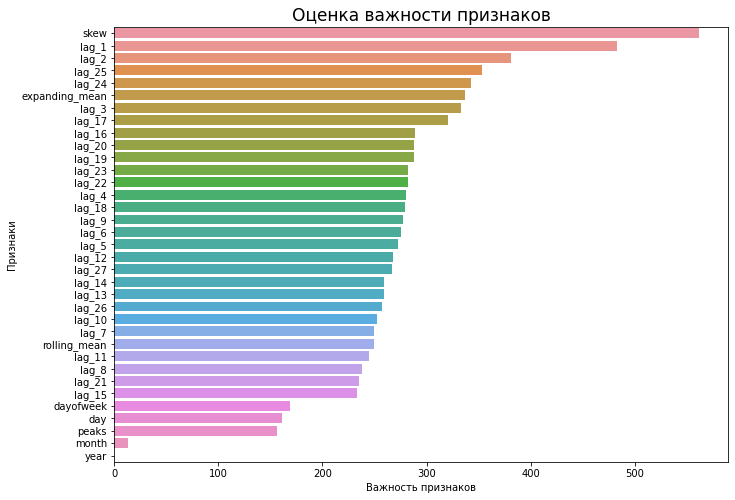

In [46]:
plt.figure(figsize=(11, 8))
sns.barplot(x=X_imp_LGBM['feature_importance'], y=X_imp_LGBM.index, order=X_imp_LGBM\
                .sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=17)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки');

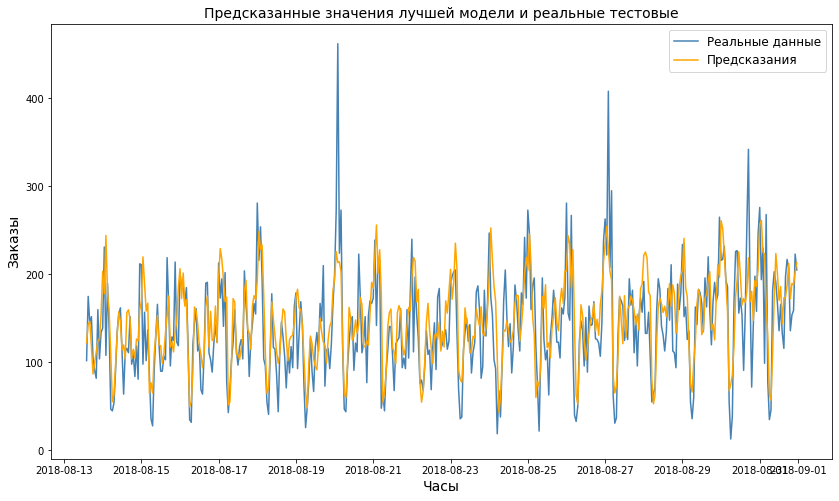

In [48]:
plt.figure(figsize = (14,8))
plt.plot(y_test, label = 'Реальные данные', color = 'steelblue')
pred_LGBM_test = pd.DataFrame(pred_LGBM_test, index=y_test.index)
plt.plot(pred_LGBM_test, label = 'Предсказания', color = 'orange')
plt.legend(fontsize=12)
plt.xlabel('Часы', fontsize=14)
plt.ylabel('Заказы', fontsize=14)
plt.title('Предсказанные значения лучшей модели и реальные тестовые', fontsize=14);

### Проверим модель на адекватность

In [49]:
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print("RMSE:", rmse(y_test, pred_previous))

RMSE: 58.856486242815066


**Метрика наших модели значительно ниже. Модель можно считать адекватной.**

**Вывод;**     
+ выбрали лучшую модель на подобранных гиперпараметрах   
+ проверили модель на вменяемость    

## Общий вывод:

**При подготовке данных:**  
+ загрузили данные     
+ выявили интервал данных        
+ выяснили, что данные идут в хронологическом порядке     
+ пропуски отсутствуют    
+ сделали ресемплирование по одному часу  

**Во втором пункте выяснили:**  

+ основной рост заказов наблюдается с начала июня      
+ основные заказы поступают в полунуночь и в 16.00.    
+ больше всего заказов в понедельник и пятницу

**На третьем этапе:**   

+ мы создвли новые признаки    
+ разбили данные на выборки   
+ подобрали гиперпараметры для моделей   

**На четвёртом этапе:**      

+ выбрали лучшую модель на подобранных гиперпараметрах   
+ проверили модель на вменяемость   

Построили модель, которая умеет прогнозировать количество заказов такси на следующий час. Значение метрики RMSE на тестовой выборке не больше 48.